In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

## 첫 취업 소요기간(준비기간) 비율

In [2]:
# 1. 엑셀 파일 경로
file_path_duration = '성별_첫 취업 소요기간 및 평균소요기간(15 ~ 24년).xlsx'


In [3]:
# 2. 파일을 header 없이 불러오기 (병합 셀 구조 대응)
df_duration_raw = pd.read_excel(file_path_duration, sheet_name='데이터', header=None)

C:\Users\samsung\anaconda\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
# 3. 1행 + 2행을 조합하여 열 이름 만들기
duration_header = df_duration_raw.iloc[0].astype(str) + '_' + df_duration_raw.iloc[1].astype(str)
duration_header.iloc[0] = '연령구분'
duration_header.iloc[1] = '성별'

In [5]:
# 4. 3행부터 데이터프레임 구성
df_duration = df_duration_raw[2:].copy()
df_duration.columns = duration_header
df_duration.reset_index(drop=True, inplace=True)

In [6]:
# 5. '15~29세 전체' 행 필터링
df_duration_youth_total = df_duration[
    (df_duration['연령구분'] == '15~29세') & (df_duration['성별'] == '전체')
].copy()

In [7]:
# 6. 연도 및 분석할 소요기간 구간 정의
duration_years = list(range(2017, 2025))
duration_labels = ['3개월 미만', '3~6개월 미만', '6개월~1년 미만',
                   '1~2년 미만', '2~3년 미만', '3년 이상']

In [8]:
# 7. 연도별 비율 계산
duration_results = []

for year in duration_years:
    try:
        # 임금근로자 수
        wage_col = f'{year}.05_임금 근로자'
        wage_total = pd.to_numeric(df_duration_youth_total[wage_col].values[0], errors='coerce')

        if pd.isna(wage_total) or wage_total == 0:
            continue

        # 구간별 인원
        period_values = []
        for label in duration_labels:
            col_key = f'{year}.05_{label}'
            val = pd.to_numeric(df_duration_youth_total[col_key].values[0], errors='coerce')
            period_values.append(val)

        if any(pd.isna(val) for val in period_values):
            continue

        # 비율 계산
        period_percentages = [round(v / wage_total * 100, 2) for v in period_values]
        row = {'연도': year, '임금근로자수': int(wage_total)}
        for i, label in enumerate(duration_labels):
            row[label] = period_percentages[i]
        duration_results.append(row)
    except:
        continue

In [9]:
# 8. 데이터프레임 생성 및 엑셀 저장
df_duration_result = pd.DataFrame(duration_results)
print("소요기간 분석 결과:")
print(df_duration_result)


소요기간 분석 결과:
     연도  임금근로자수  3개월 미만  3~6개월 미만  6개월~1년 미만  1~2년 미만  2~3년 미만  3년 이상
0  2017    4012   50.00     13.51       8.77    11.59     6.43   9.70
1  2018    4054   49.61     12.01      10.80    11.54     6.96   9.08
2  2019    4070   49.51     12.83       9.95    11.70     6.54   9.51
3  2020    3963   49.21     13.42      11.33    11.88     6.33   7.80
4  2021    3953   47.41     14.07      11.89    11.74     6.75   8.17
5  2022    4018   48.95     12.00      10.18    13.14     6.84   8.91
6  2023    3865   48.90     11.82      10.87    13.12     6.91   8.38
7  2024    3671   47.67     11.22      11.06    13.38     6.95   9.72


## 퇴사율 분석

In [10]:
# 1. 엑셀 파일 경로
file_path_econ = '연령별 경제활동 상태 (2).xlsx'

In [11]:
# 2. 엑셀 파일에서 '데이터' 시트 불러오기
df_econ = pd.read_excel(file_path_econ, sheet_name='데이터')

C:\Users\samsung\anaconda\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [12]:
# 3. '연령별'이 '* 15~29세'이고 '수학여부'가 '전체'인 행 필터링
df_econ_target = df_econ[(df_econ['연령별'] == '* 15~29세') & (df_econ['수학여부'] == '전체')].copy()


In [13]:
# 4. 분석 대상 연도
econ_years = list(range(2017, 2025))

In [14]:
# 5. 실업률 계산
econ_results = []
for year in econ_years:
    try:
        econ_pop = pd.to_numeric(df_econ_target[f'{year}.05.1'].values[0], errors='coerce')  # 경제활동인구
        unemployed = pd.to_numeric(df_econ_target[f'{year}.05.3'].values[0], errors='coerce')  # 실업자

        if pd.isna(econ_pop) or econ_pop == 0 or pd.isna(unemployed):
            continue

        rate = round(unemployed / econ_pop * 100, 2)
        econ_results.append({
            '연도': year,
            '경제활동인구': int(econ_pop),
            '실업자': int(unemployed),
            '퇴사율': rate
        })
    except:
        continue


In [15]:
# 6. 결과를 데이터프레임으로 저장 및 출력
df_econ_result = pd.DataFrame(econ_results)
print("\n경제활동 상태 분석 결과:")
print(df_econ_result)


경제활동 상태 분석 결과:
     연도  경제활동인구  실업자    퇴사율
0  2017    4410  408   9.25
1  2018    4368  460  10.53
2  2019    4390  437   9.95
3  2020    4196  426  10.15
4  2021    4310  402   9.33
5  2022    4425  320   7.23
6  2023    4252  247   5.81
7  2024    4107  276   6.72


## 상관관계 분석

In [16]:
# 1. 연도 기준으로 데이터프레임 병합
df_corr = pd.merge(
    df_duration_result[['연도', '3개월 미만']],
    df_econ_result[['연도', '퇴사율']],
    on='연도',
    how='inner'
)

In [17]:
# 2. 상관계수 계산 (피어슨)
correlation = df_corr['3개월 미만'].corr(df_corr['퇴사율'])

In [18]:
# 3. 결과 출력
print("\n[상관관계 분석 결과]")
print(df_corr)
print(f"\n'3개월 미만' 소요기간 비율과 실업률간의 피어슨 상관계수: {round(correlation, 3)}")



[상관관계 분석 결과]
     연도  3개월 미만    퇴사율
0  2017   50.00   9.25
1  2018   49.61  10.53
2  2019   49.51   9.95
3  2020   49.21  10.15
4  2021   47.41   9.33
5  2022   48.95   7.23
6  2023   48.90   5.81
7  2024   47.67   6.72

'3개월 미만' 소요기간 비율과 실업률간의 피어슨 상관계수: 0.397


## 시각화

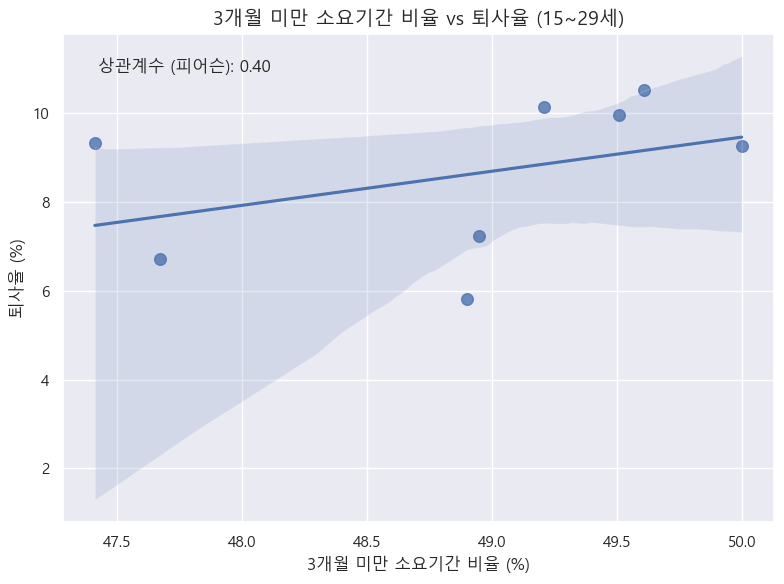

In [19]:
# 1. 산점도 + 회귀선
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_corr,
    x='3개월 미만',
    y='퇴사율',
    ci=95,  # 신뢰구간 표시 제거
    scatter_kws={'s': 70}
)

# 2. 제목 및 축 라벨
plt.title("3개월 미만 소요기간 비율 vs 퇴사율 (15~29세)", fontsize=14)
plt.xlabel("3개월 미만 소요기간 비율 (%)", fontsize=12)
plt.ylabel("퇴사율 (%)", fontsize=12)

# 3. 상관계수 표시
plt.text(
    0.05, 0.95,
    f"상관계수 (피어슨): {correlation:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

## 6개월 미만

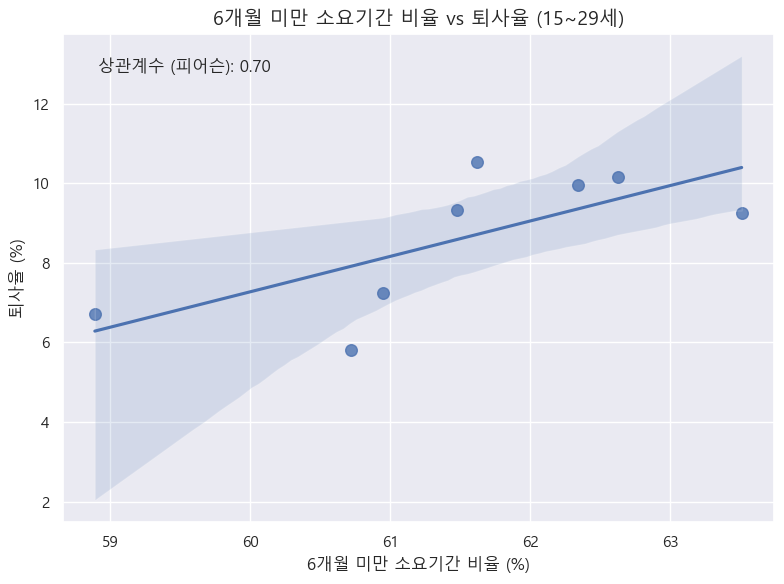

In [20]:
# 6개월 미만 소요기간 비율 계산
df_duration_result['6개월 미만'] = (
    pd.to_numeric(df_duration_result['3개월 미만'], errors='coerce') +
    pd.to_numeric(df_duration_result['3~6개월 미만'], errors='coerce')
)

# 실업률 데이터 준비
df_econ_result['퇴사율'] = pd.to_numeric(df_econ_result['퇴사율'], errors='coerce')

# 두 데이터 병합
df_corr_6mo = pd.merge(
    df_duration_result[['연도', '6개월 미만']],
    df_econ_result[['연도', '퇴사율']],
    on='연도',
    how='inner'
).dropna()

# 상관계수 계산
correlation_6mo = df_corr_6mo['6개월 미만'].corr(df_corr_6mo['퇴사율'])

# 시각화
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_corr_6mo,
    x='6개월 미만',
    y='퇴사율',
    scatter_kws={'s': 70},
    ci=95
)

plt.title("6개월 미만 소요기간 비율 vs 퇴사율 (15~29세)", fontsize=14)
plt.xlabel("6개월 미만 소요기간 비율 (%)", fontsize=12)
plt.ylabel("퇴사율 (%)", fontsize=12)

# 상관계수 표시
plt.text(
    0.05, 0.95,
    f"상관계수 (피어슨): {correlation_6mo:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

### 6개월 미만 소요기간 비율 vs 퇴사율 상관관계 결과 분석

- 졸업 후 6개월 이내에 취업한 비율과 퇴사율 사이에는 강한 양의 상관관계(r = 0.70) 가 존재한다. 
- 이는 조기취업 비율이 높은 해일수록 퇴사율도 높아졌다는 것을 보여준다.


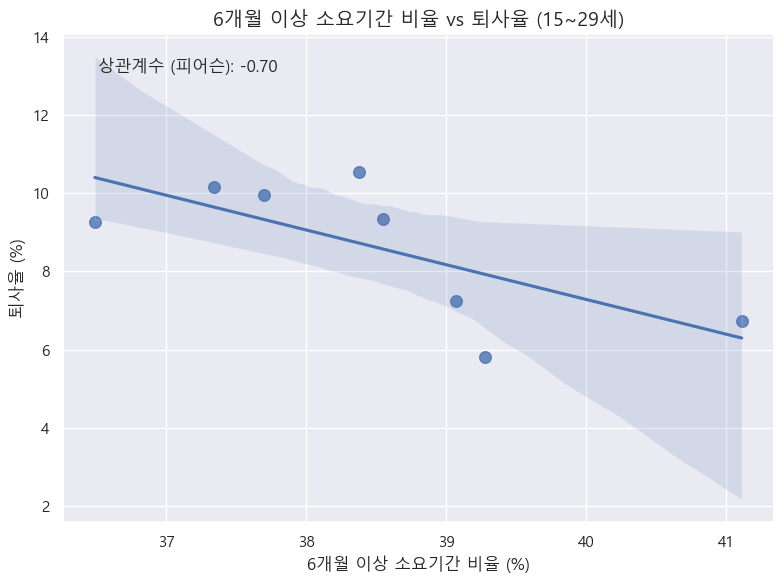

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 6개월 이상 소요 비율 계산
df_duration_result['6개월 이상'] = (
    pd.to_numeric(df_duration_result['6개월~1년 미만'], errors='coerce') +
    pd.to_numeric(df_duration_result['1~2년 미만'], errors='coerce') +
    pd.to_numeric(df_duration_result['2~3년 미만'], errors='coerce') +
    pd.to_numeric(df_duration_result['3년 이상'], errors='coerce')
)

# 퇴사율 숫자형 변환
df_econ_result['퇴사률'] = pd.to_numeric(df_econ_result['퇴사율'], errors='coerce')  # 또는 '퇴사율' 열이 있다면 그걸로 교체

# 병합
df_corr_6mo_plus = pd.merge(
    df_duration_result[['연도', '6개월 이상']],
    df_econ_result[['연도', '퇴사율']],  # 또는 '퇴사율' 열
    on='연도',
    how='inner'
).dropna()

# 상관계수 계산
correlation_6mo_plus = df_corr_6mo_plus['6개월 이상'].corr(df_corr_6mo_plus['퇴사율'])  # 또는 '퇴사율'

# 시각화
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_corr_6mo_plus,
    x='6개월 이상',
    y='퇴사율',  # 또는 '퇴사율'
    scatter_kws={'s': 70},
    ci=95
)

plt.title("6개월 이상 소요기간 비율 vs 퇴사율 (15~29세)", fontsize=14)
plt.xlabel("6개월 이상 소요기간 비율 (%)", fontsize=12)
plt.ylabel("퇴사율 (%)", fontsize=12)

plt.text(
    0.05, 0.95,
    f"상관계수 (피어슨): {correlation_6mo_plus:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()


### 6개월 이상 소요기간 비율 vs 퇴사율 상관관계 결과 분석

- 6개월 이상 소요된 취업자의 비율과 퇴사율 사이에 강한 음의 상관관계(r = –0.70) 가 나타났다.
- 이는 취업 준비기간이 길수록 오히려 퇴사율이 낮아지는 경향이 있음을 보여준다.
- 즉, 충분한 준비와 탐색을 거친 취업이 더 안정적인 근속으로 이어질 가능성을 시사한다.

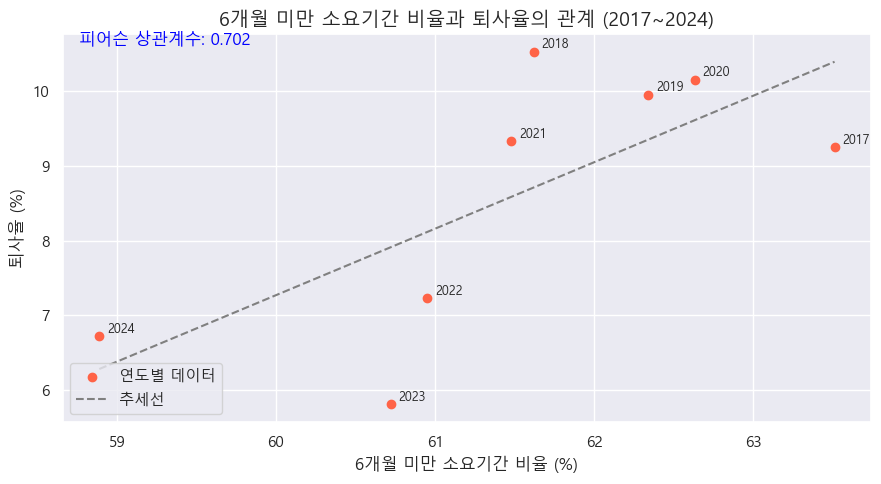

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# 기존 병합된 데이터프레임 사용
df_plot = df_corr_6mo.copy()  # ← 6개월 미만 vs 퇴사율 데이터
df_plot['연도'] = df_plot['연도'].astype(str)

# x, y 값 정의
x = df_plot['6개월 미만']
y = df_plot['퇴사율']  # 또는 퇴사율 열 이름
years = df_plot['연도']

# 회귀선 계산
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line_x = np.linspace(min(x), max(x), 100)
line_y = slope * line_x + intercept

# 그래프 그리기
plt.figure(figsize=(9, 5))
plt.scatter(x, y, color='tomato', label='연도별 데이터')  # 산점도
plt.plot(line_x, line_y, color='gray', linestyle='--', label='추세선')  # 회귀선 (점선)

# 각 점에 연도 텍스트 추가
for i in range(len(df_plot)):
    plt.text(x.iloc[i] + 0.05, y.iloc[i] + 0.05, years.iloc[i], fontsize=9)

# 상관계수 텍스트 (왼쪽 상단)
plt.text(0.02, 0.97, f'피어슨 상관계수: {r_value:.3f}', color='blue',
         transform=plt.gca().transAxes, fontsize=12)

# 제목 및 축 라벨
plt.title("6개월 미만 소요기간 비율과 퇴사율의 관계 (2017~2024)", fontsize=14)
plt.xlabel("6개월 미만 소요기간 비율 (%)", fontsize=12)
plt.ylabel("퇴사율 (%)", fontsize=12)

# 기타 스타일
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


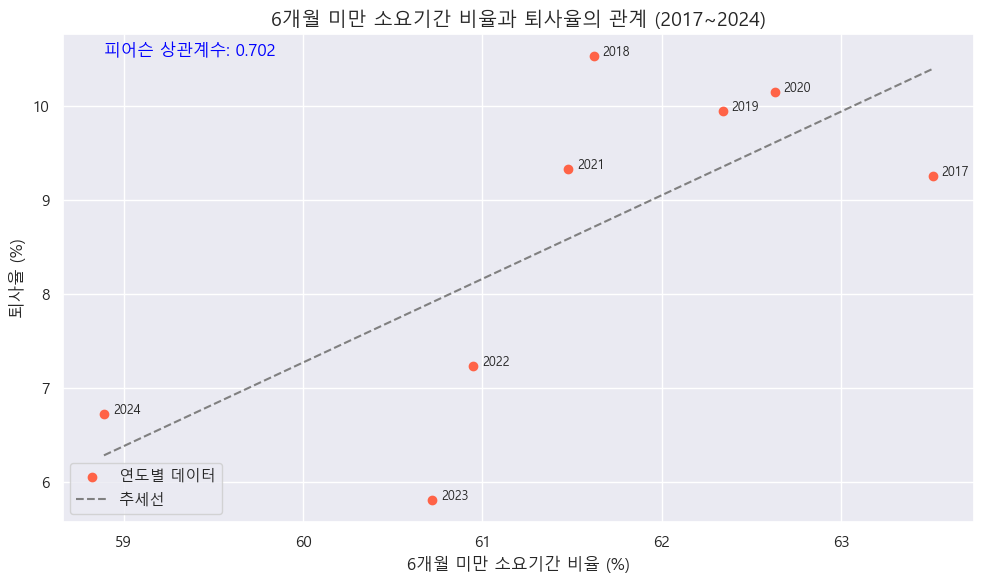

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# 연도별 x, y 데이터 추출
x = df_corr_6mo['6개월 미만'].values
y = df_corr_6mo['퇴사율'].values  # 또는 '퇴사율'로 이름이 바뀌었다면 수정
years = df_corr_6mo['연도'].astype(str).values

# 상관계수 및 회귀선 계산
slope, intercept, r_value, _, _ = linregress(x, y)
line_x = np.linspace(min(x), max(x), 100)
line_y = slope * line_x + intercept

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='tomato', label='연도별 데이터')

# 연도 텍스트 라벨 추가
for i in range(len(x)):
    plt.text(x[i] + 0.05, y[i], years[i], fontsize=9)

# 추세선 추가
plt.plot(line_x, line_y, color='gray', linestyle='--', label='추세선')

# 라벨 및 제목
plt.xlabel('6개월 미만 소요기간 비율 (%)', fontsize=12)
plt.ylabel('퇴사율 (%)', fontsize=12)
plt.title('6개월 미만 소요기간 비율과 퇴사율의 관계 (2017~2024)', fontsize=14)

# 상관계수 텍스트
plt.text(min(x), max(y), f'피어슨 상관계수: {r_value:.3f}', fontsize=12, color='blue')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


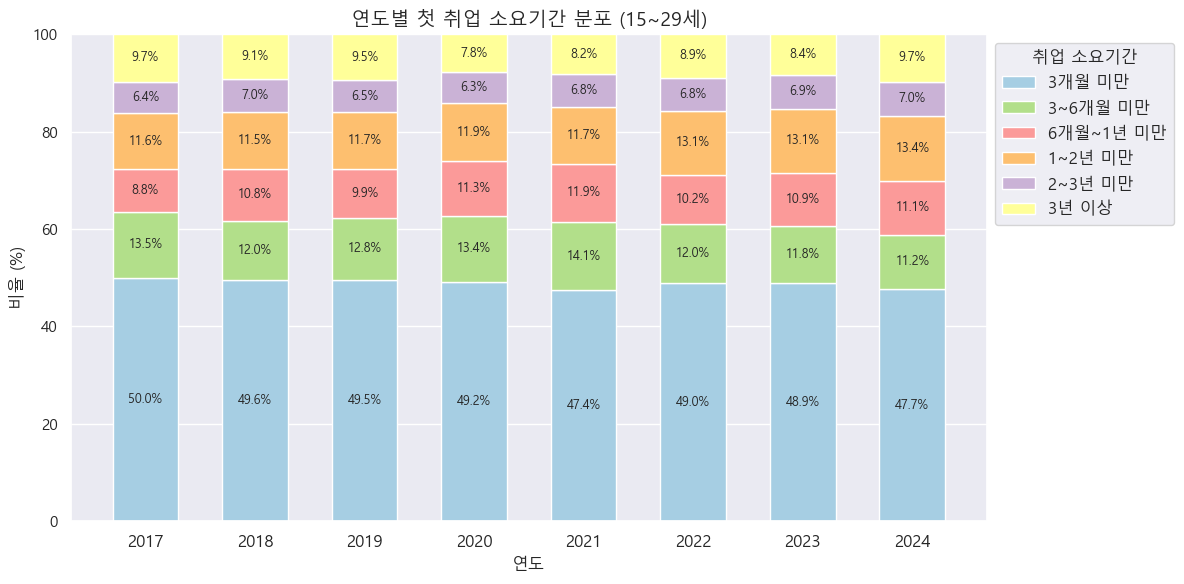

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# 👉 데이터프레임: df_duration_result 사용
# 👉 분석 대상 열 정의
year_col = '연도'
duration_cols = ['3개월 미만', '3~6개월 미만', '6개월~1년 미만', '1~2년 미만', '2~3년 미만', '3년 이상']

# 👉 연도 및 소요기간 비율 데이터 추출
years = df_duration_result[year_col].astype(str).tolist()
duration_data = df_duration_result[duration_cols]

# 👉 색상: 파스텔톤 6색
pastel_colors = ['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6', '#ffff99']

# 👉 그래프 준비
x = np.arange(len(years))
bar_width = 0.6
bottom = np.zeros(len(years))

plt.figure(figsize=(12, 6))

for i, col in enumerate(duration_cols):
    values = duration_data[col].values
    plt.bar(x, values, bar_width, bottom=bottom, label=col, color=pastel_colors[i])
    
    # 퍼센트 텍스트 추가
    for j in range(len(x)):
        y_pos = bottom[j] + values[j] / 2
        if values[j] >= 5:
            plt.text(x[j], y_pos, f'{values[j]:.1f}%', ha='center', va='center', fontsize=9)
    
    bottom += values

# 👉 폰트 (한글 대응: Windows 사용자용)
font_path = "C:/Windows/Fonts/malgun.ttf"
fontprop = fm.FontProperties(fname=font_path)

plt.xticks(x, years, fontproperties=fontprop)
plt.xlabel("연도", fontproperties=fontprop)
plt.ylabel("비율 (%)", fontproperties=fontprop)
plt.title("연도별 첫 취업 소요기간 분포 (15~29세)", fontproperties=fontprop, fontsize=14)
plt.ylim(0, 100)


plt.legend(title="취업 소요기간", prop=fontprop, title_fontproperties=fontprop, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


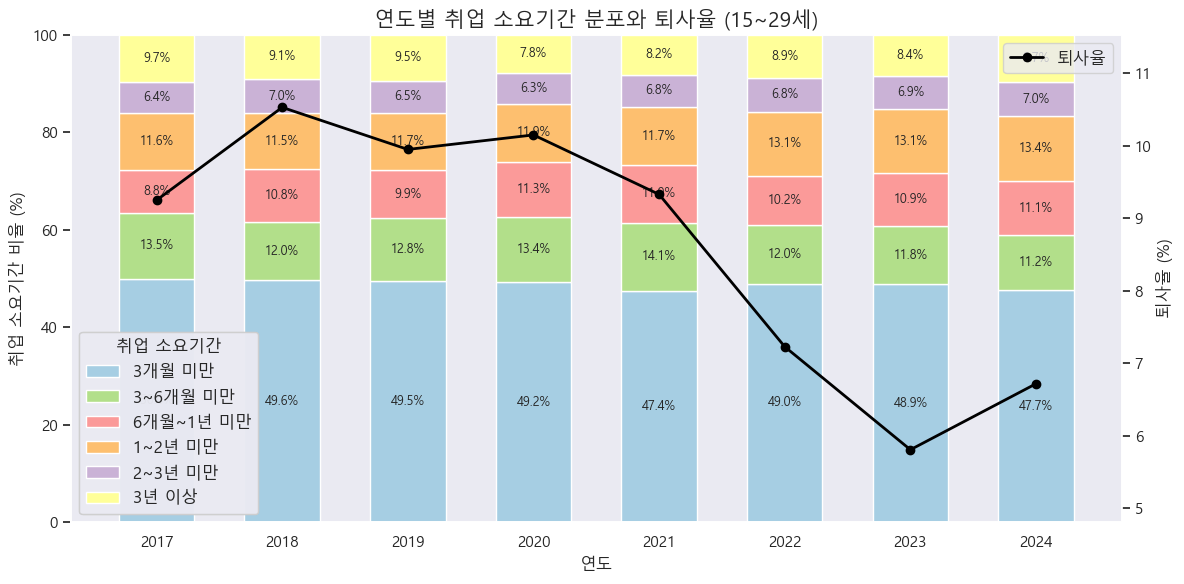

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# ✅ 한글 폰트 설정 (윈도우 기준)
font_path = "C:/Windows/Fonts/malgun.ttf"
fontprop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = fontprop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# ✅ 소요기간 컬럼 및 색상
duration_cols = ['3개월 미만', '3~6개월 미만', '6개월~1년 미만', '1~2년 미만', '2~3년 미만', '3년 이상']
colors = ['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6', '#ffff99']  # 파스텔톤

# ✅ x축 (연도)
years = df_duration_result['연도'].astype(str).tolist()
x = np.arange(len(years))

# ✅ 퇴사율 데이터
resign_rate = df_econ_result['퇴사율'].values

# ✅ 그래프 생성
fig, ax1 = plt.subplots(figsize=(12, 6))

# ✅ 누적 막대그래프
bottom = np.zeros(len(years))
for i, col in enumerate(duration_cols):
    values = df_duration_result[col].values
    bars = ax1.bar(x, values, width=0.6, bottom=bottom, label=col, color=colors[i])
    
    for j in range(len(x)):
        y = bottom[j] + values[j] / 2
        if values[j] >= 5:
            ax1.text(x[j], y, f'{values[j]:.1f}%', ha='center', va='center', fontsize=9)
    
    bottom += values

# ✅ 왼쪽 축 설정
ax1.set_xticks(x)
ax1.set_xticklabels(years)
ax1.set_xlabel("연도", fontsize=12)
ax1.set_ylabel("취업 소요기간 비율 (%)", fontsize=12)
ax1.set_ylim(0, 100)
ax1.set_title("연도별 취업 소요기간 분포와 퇴사율 (15~29세)", fontsize=15)

# ✅ 선그래프 (퇴사율) - 우측 y축
ax2 = ax1.twinx()
ax2.plot(x, resign_rate, color='black', marker='o', linewidth=2, label='퇴사율')
ax2.set_ylabel("퇴사율 (%)", fontsize=12)
ax2.set_ylim(min(resign_rate) - 1, max(resign_rate) + 1)


# ✅ 범례: 왼쪽 아래로 이동
bars_legend = ax1.legend(
    title="취업 소요기간", 
    loc='lower left', 
    prop=fontprop, 
    title_fontproperties=fontprop
)


# ✅ 그리드 제거
ax1.grid(False)
ax2.grid(False)

# ✅ 선 그래프 범례 (퇴사율): 오른쪽 위 그대로
line_legend = ax2.legend(loc='upper right', prop=fontprop)

# ✅ 막대 범례 붙이기
ax1.add_artist(bars_legend)

plt.tight_layout()
plt.show()


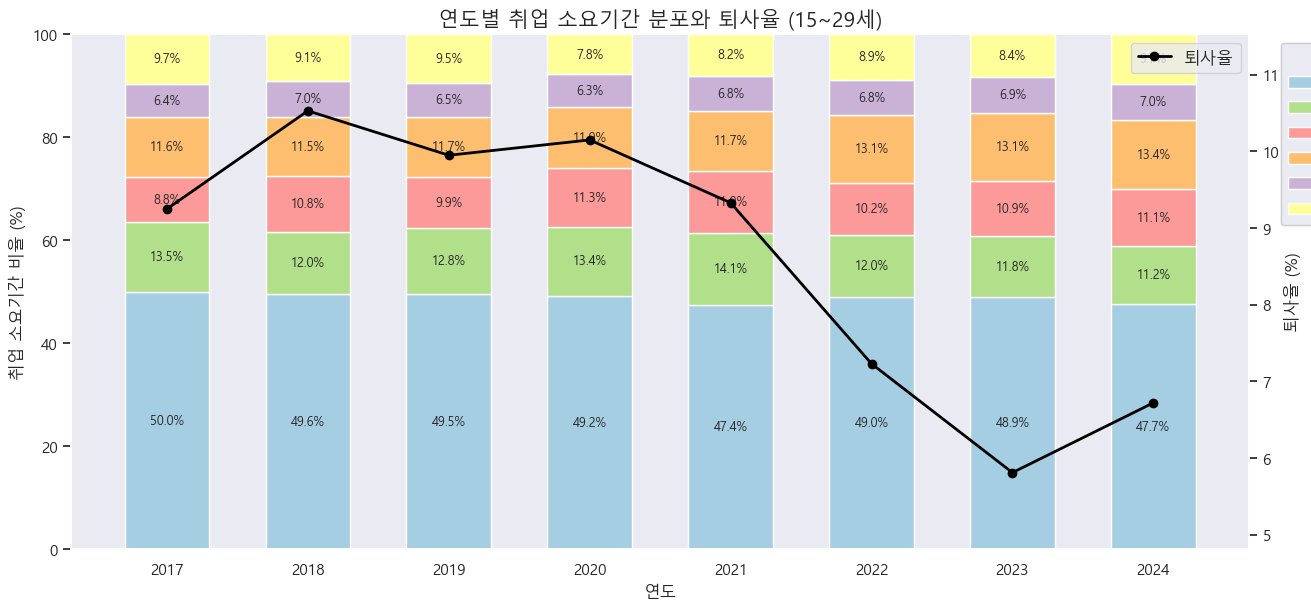

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# ✅ 한글 폰트 설정 (윈도우 기준)
font_path = "C:/Windows/Fonts/malgun.ttf"
fontprop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = fontprop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# ✅ 소요기간 컬럼 및 색상
duration_cols = ['3개월 미만', '3~6개월 미만', '6개월~1년 미만', '1~2년 미만', '2~3년 미만', '3년 이상']
colors = ['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6', '#ffff99']  # 파스텔톤

# ✅ x축 (연도)
years = df_duration_result['연도'].astype(str).tolist()
x = np.arange(len(years))

# ✅ 퇴사율 데이터
resign_rate = df_econ_result['퇴사율'].values

# ✅ 그래프 생성: 자동 여백 확보를 위한 constrained_layout
fig, ax1 = plt.subplots(figsize=(13, 6), constrained_layout=True)

# ✅ 누적 막대그래프
bottom = np.zeros(len(years))
for i, col in enumerate(duration_cols):
    values = df_duration_result[col].values
    bars = ax1.bar(x, values, width=0.6, bottom=bottom, label=col, color=colors[i])
    
    for j in range(len(x)):
        y = bottom[j] + values[j] / 2
        if values[j] >= 5:
            ax1.text(x[j], y, f'{values[j]:.1f}%', ha='center', va='center', fontsize=9)
    
    bottom += values

# ✅ 왼쪽 축 설정
ax1.set_xticks(x)
ax1.set_xticklabels(years)
ax1.set_xlabel("연도", fontsize=12)
ax1.set_ylabel("취업 소요기간 비율 (%)", fontsize=12)
ax1.set_ylim(0, 100)
ax1.set_title("연도별 취업 소요기간 분포와 퇴사율 (15~29세)", fontsize=15)

# ✅ 선그래프 (퇴사율) - 우측 y축
ax2 = ax1.twinx()
ax2.plot(x, resign_rate, color='black', marker='o', linewidth=2, label='퇴사율')
ax2.set_ylabel("퇴사율 (%)", fontsize=12)
ax2.set_ylim(min(resign_rate) - 1, max(resign_rate) + 1)

# ✅ 범례 - 막대그래프 범례를 오른쪽 바깥에 표시
bars_legend = ax1.legend(
    title="취업 소요기간", 
    loc='upper left', 
    bbox_to_anchor=(1.02, 1), 
    prop=fontprop, 
    title_fontproperties=fontprop
)

# ✅ 선 범례 추가 (퇴사율)
line_legend = ax2.legend(loc='upper right', prop=fontprop)

# ✅ 그리드 제거
ax1.grid(False)
ax2.grid(False)

# ✅ 범례를 메인 축에 추가
ax1.add_artist(bars_legend)

plt.show()
